## Context
The dataset consists of data collected from heavy Scania trucks in everyday usage. The system in focus is the Air Pressure system (APS) which generates pressurized air that is utilized in various functions in a truck, such as braking and gear changes. The datasets' positive class consists of component failures for a specific component of the APS system. The negative class consists of trucks with failures for components not related to the APS. The data consists of a subset of all available data, selected by experts.

## Idea
The idea here is to provide an algorithm for Root Cause Analysis, such that it's possible to include in different subsystems and when a system fails the maintenance team already has an idea for where to look. 

## Content
The training set contains 60000 examples in total in which 59000 belong to the negative class and 1000 positive class. The test set contains 16000 examples. There are 171 attributes per record.

The attribute names of the data have been anonymized for proprietary reasons. It consists of both single numerical counters and histograms consisting of bins with different conditions. Typically the histograms have open-ended conditions at each end. For example, if we measuring the ambient temperature "T" then the histogram could be defined with 4 bins where:

The attributes are as follows: class, then anonymized operational data. The operational data have an identifier and a bin id, like "Identifier_Bin". In total there are 171 attributes, of which 7 are histogram variables. Missing values are denoted by "na".

## Acknowledgements
This file is part of APS Failure and Operational Data for Scania Trucks. It was imported from the [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks).

## Inspiration
The total cost of a prediction model the sum of Cost_1 multiplied by the number of Instances with type 1 failure and Cost_2 with the number of instances with type 2 failure, resulting in a Total_cost. In this case Cost_1 refers to the cost that an unnecessary check needs to be done by an mechanic at an workshop, while Cost_2 refer to the cost of missing a faulty truck, which may cause a breakdown. Cost_1 = 10 and Cost_2 = 500, and Total_cost = Cost_1*No_Instances + Cost_2*No_Instances.

In [4]:
import io
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
### Viz imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import missingno as msno
from mlxtend.plotting import plot_decision_regions
import numpy as np
import pandas as pd
import visualizer as viz
import utils
import math

In [5]:
import numpy as np
import pandas as pd
import pickle
from scipy import stats
import math
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

# basic data science modules
from sklearn import datasets
import numpy as np
import pandas as pd
from scipy import stats
import math

# visualization modules
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from IPython.core.display import HTML
from mlxtend.plotting import plot_decision_regions

import xgboost as xgb
from xgboost import XGBClassifier

# sklean model selection http://scikit-learn.org/
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel

import eli5
from eli5.sklearn import PermutationImportance

import visualizer as viz

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
path = 'data/aps_failure_training_set.csv'
features = pd.read_csv(path, na_values="na")
features.shape

(60000, 171)

In [7]:
Y = features.iloc[:, 1:2].copy()
X = features.iloc[:, 2:].copy()
print(Y.shape)
print(X.shape)

(60000, 1)
(60000, 169)


In [8]:
X.head()

,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


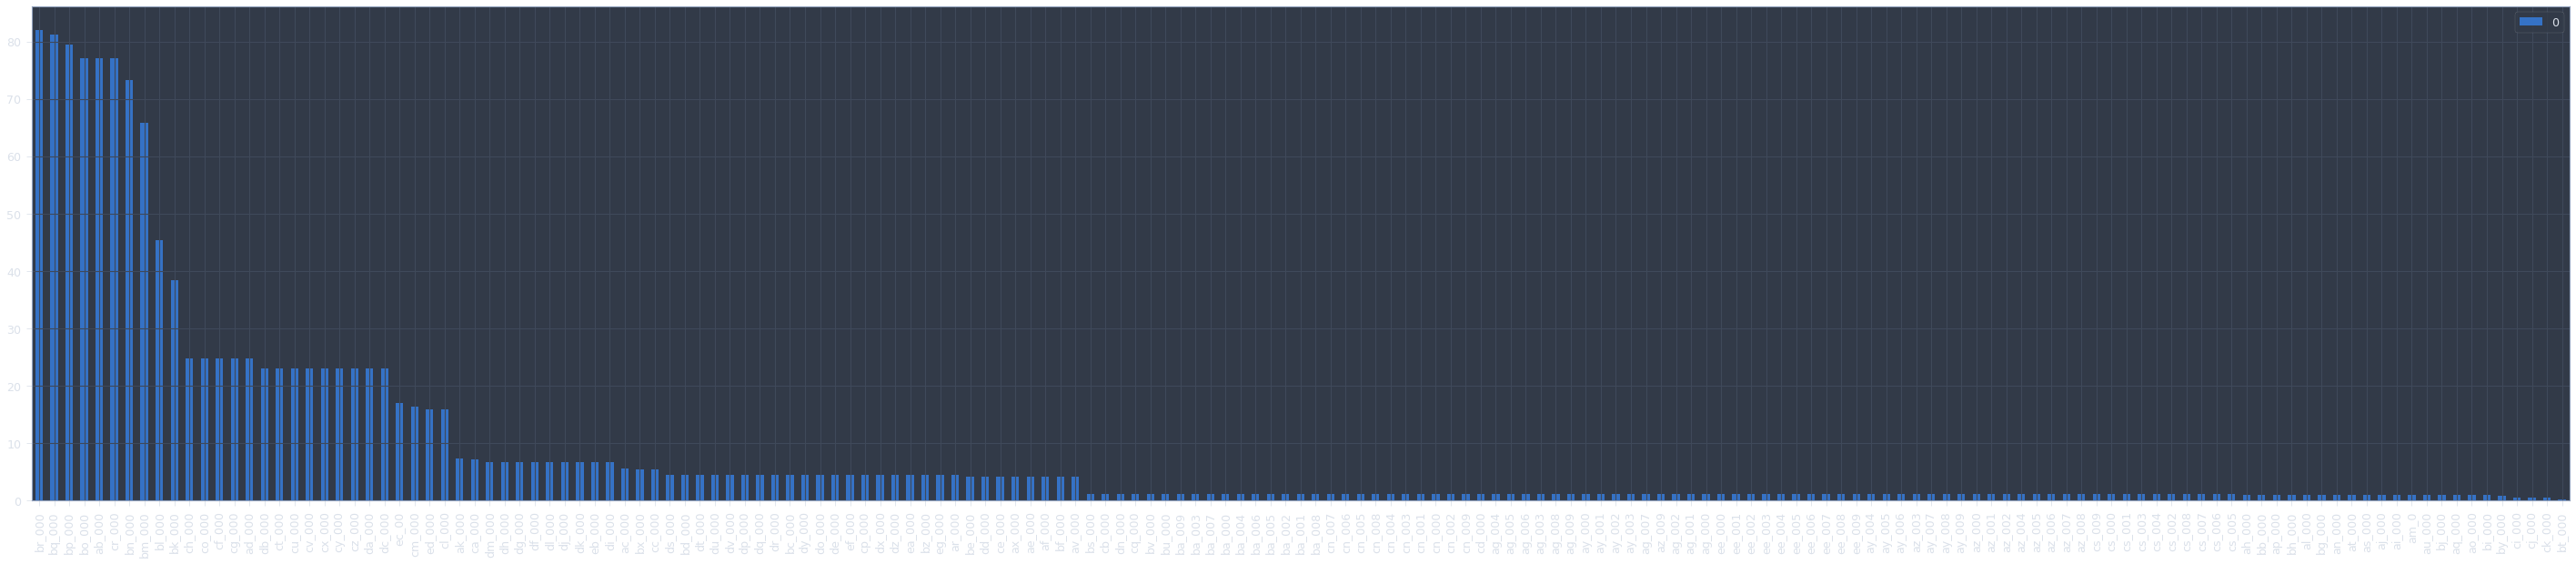

In [9]:
missing = X.isna().sum().div(X.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
missing.plot.bar(figsize=(50,10))

# Feature Importance
![features](https://media.giphy.com/media/c6J4HiJ8aNRSBrMYfH/giphy.gif)
Not every feature has the same impact on the model, therefore, we'll try to figure out which features have the highest impact on prediction and remove the rest.
We're gonna do that in 2 parts:

1. Replace null values with the mean so they don't affect prediction*
2. Permutações de importância

> *There is a chance that the fact that some variables being missing is a prediction factor, but we'll ignore it for now and replace them with the mean

In [10]:
X = utils.drop_min_unique_features(X, 1) # Remove features with the same value for every instance or are exclusively null
X.fillna(X.mean(), inplace=True)
X.astype('float', copy=False)

,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.713189,6.640000e+02,186.000000,0.0,0.0,0.0,0.0,0.0,2564.0,59100.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,0.713189,2.130707e+09,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,104.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,0.000000,2.130706e+09,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,28.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,0.713189,2.130706e+09,494.000000,0.0,0.0,0.0,0.0,0.0,0.0,330.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


### Permutation importance

In [11]:
def feature_importance(X, y, threshold=0.005):
    estimator = GradientBoostingClassifier(
        max_depth=3,
        subsample=0.8,
        verbose=1,  
        random_state=73
    )
    estimator.fit(X, np.array(y).ravel())
    print('|-------|')

    select = SelectFromModel(estimator, threshold=threshold, prefit=True)
    return select.transform(X)

In [ ]:
x_features = feature_importance(X, Y)